In [1056]:
import numpy as np
import matplotlib.pyplot as plt
import nnfs.datasets


In [1057]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [1058]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [1059]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [1060]:
class Dense:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(output_dim, input_dim) * 0.01
        self.biases = np.zeros(output_dim)
    
    def forward(self, x):
        self.input = x           
        self.output = x @ self.weights.T + self.biases  
        return self.output
    
    def backward(self, dL_dout):
        self.dweights = dL_dout.T @ self.input  
        self.dbias = np.sum(dL_dout, axis=0) 
        dL_dinput = dL_dout @ self.weights  
        return dL_dinput


In [1061]:
class ReluAct:
    def forward(self, x):
        self.input = x
        self.output = np.maximum(0, x)
        return self.output
    
    def backward(self, dL_dout):
        dL_dinput = dL_dout * (self.input > 0).astype(float)
        return dL_dinput


In [1062]:
class Softmax:
    def forward(self, x):
        max_row = np.max(x, axis=1, keepdims=True)
        normalize_row = x - max_row
        expo = np.exp(normalize_row)
        self.output = expo / np.sum(expo, axis=1, keepdims=True)
        return self.output



In [1063]:
class CrossEntropyLoss:
    def forward(self, y_pred, y_true):
        if y_true.ndim == 2 and y_true.shape[1] != y_pred.shape[1]:
            raise ValueError("y_true shape does not match y_pred classes")
        if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
            y_one_hot = np.zeros_like(y_pred)
            y_one_hot[np.arange(y_true.size), y_true.flatten()] = 1
            y_true = y_one_hot
        
        y_pred_clipped = np.clip(y_pred, 1e-12, 1.0)
        sample_losses = -np.sum(y_true * np.log(y_pred_clipped), axis=1)
        self.y_pred = y_pred
        self.y_true = y_true
        return np.mean(sample_losses)
    
    def backward(self):
        n_samples = self.y_true.shape[0]
        dL_dy = (self.y_pred - self.y_true) / n_samples
        return dL_dy



In [1064]:
class SGDOptimizerMomentum:
    def __init__(self, layer,lr,betaDecay=0.01):
        self.vt = 0
        self.lr=lr
        self.beta = betaDecay
        self.layer = layer
        self.vt_w = np.zeros_like(self.layer.weights)
        self.vt_b = np.zeros_like(self.layer.biases)

        
    def update(self):
        self.vt_w = self.beta * self.vt_w + self.lr * self.layer.dweights
        self.vt_b = self.beta * self.vt_b + self.lr * self.layer.dbias

        weights = self.layer.weights - self.vt_w
        bias = self.layer.biases - self.vt_b

        return weights,bias



In [1065]:
    
class SGDOptimizer:
    def __init__(self,betaDecay,learning_rate=0.001):
        self.lr = learning_rate
        self.beta = betaDecay
        self.momentum = None  
    def update(self,layer):
        if self.beta==0:
            layer.weights = layer.weights - self.lr * layer.dweights 
            layer.biases = layer.biases - self.lr * layer.dbias
        else:
            if self.momentum is None:
                self.momentum = SGDOptimizerMomentum(layer, self.lr, self.beta)
            layer.weights, layer.biases = self.momentum.update()
        
    
        


In [1066]:
def accuracy(y_pred, y_true):
    """Calculate accuracy"""
    y_pred_classes = np.argmax(y_pred, axis=1)
    return np.mean(y_pred_classes == y_true)


In [1067]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)


In [1068]:
# X, y = nnfs.datasets.spiral_data(samples=10000, classes=5)
# x_train = X[0:8000]
# y_train = y[0:8000]
# x_test = X[8000:10000]
# y_test = y[8000:10000]


In [1069]:
x_train 


array([[-0.00000000e+00,  0.00000000e+00],
       [ 8.47942513e-05,  5.30276837e-05],
       [-2.78599920e-05,  1.98070245e-04],
       ...,
       [ 6.90875473e-01, -4.02913259e-01],
       [ 7.36195852e-01,  3.12767746e-01],
       [ 6.15040521e-01, -5.11559532e-01]], shape=(8000, 2))

In [1070]:
y_train 


array([1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 0, 1, 2, 0,
       2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2,
       2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2,
       1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 2,
       1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

In [1071]:
x_test


array([[ 0.74122227,  0.30119357],
       [ 0.78743419, -0.1422514 ],
       [ 0.78453849,  0.1579477 ],
       ...,
       [-0.23588225, -0.97157581],
       [-0.92956583, -0.36838479],
       [-0.84671271, -0.53205036]], shape=(2000, 2))

In [1072]:
y_test

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2])

In [1073]:
# X, y = nnfs.datasets.spiral_data(samples=10000, classes=2)
# x_train = X[0:8000]
# y_train = y[0:8000]
# x_test = X[8000:10000]
# y_test = y[8000:10000]


In [1074]:
# plt.figure(figsize=(8, 6))
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.6)
# plt.title('Spiral Dataset')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.show()


In [1075]:
# # Much harder problem - more classes
# X, y = nnfs.datasets.spiral_data(samples=10000, classes=5)
# x_train = X[0:8000]
# y_train = y[0:8000]
# x_test = X[8000:10000]
# y_test = y[8000:10000]

# # # Smaller network
# # # Lower learning rate

# # # Add heavier noise
# # x_train_noisy = x_train + np.random.randn(*x_train.shape) * 5
# # x_test_noisy = x_test + np.random.randn(*x_test.shape) * 5

In [1076]:
np.random.seed(42)

dense = Dense(input_dim=4, output_dim=3)
relu = ReluAct()
softmax = Softmax()
loss_func = CrossEntropyLoss()
optimizer = SGDOptimizer(learning_rate=0.001,betaDecay=0)

losses = []
accuracies = []

for it in range(100000):
    z = dense.forward(X_train)
    a = relu.forward(z)
    y_pred = softmax.forward(a)
    loss = loss_func.forward(y_pred, y_train)
    
    dL = loss_func.backward()
    dL = relu.backward(dL)
    dL = dense.backward(dL)
    optimizer.update(dense)
    
    acc = accuracy(y_pred, y_train.flatten())
    losses.append(loss)
    accuracies.append(acc)
    
    if it % 500 == 0:
        print(f"iter {it:05d}  loss {loss:.6f}  acc {acc:.4f}")

print("Training complete!")

iter 00000  loss 1.107986  acc 0.3100
iter 00500  loss 1.088746  acc 0.4600
iter 01000  loss 1.087069  acc 0.4800
iter 01500  loss 1.085931  acc 0.4900
iter 02000  loss 1.084905  acc 0.4900
iter 02500  loss 1.083965  acc 0.5000
iter 03000  loss 1.083056  acc 0.5000
iter 03500  loss 1.082164  acc 0.5100
iter 04000  loss 1.081288  acc 0.5000
iter 04500  loss 1.080429  acc 0.5000
iter 05000  loss 1.079585  acc 0.5100
iter 05500  loss 1.078756  acc 0.5000
iter 06000  loss 1.077944  acc 0.5000
iter 06500  loss 1.077146  acc 0.5000
iter 07000  loss 1.076363  acc 0.5000
iter 07500  loss 1.075593  acc 0.5100
iter 08000  loss 1.074836  acc 0.5100
iter 08500  loss 1.074093  acc 0.5100
iter 09000  loss 1.073362  acc 0.5100
iter 09500  loss 1.072644  acc 0.5100
iter 10000  loss 1.071938  acc 0.5100
iter 10500  loss 1.071245  acc 0.5000
iter 11000  loss 1.070574  acc 0.5100
iter 11500  loss 1.069919  acc 0.5100
iter 12000  loss 1.069274  acc 0.5100
iter 12500  loss 1.068641  acc 0.5100
iter 13000  

In [1077]:
np.random.seed(42)
dense = Dense(input_dim=4, output_dim=3)
relu = ReluAct()
softmax = Softmax()
loss_func = CrossEntropyLoss()
optimizer = SGDOptimizer(learning_rate=0.001,betaDecay=0.001)

losses = []
accuracies = []

for it in range(100000):
    z = dense.forward(X_train)
    a = relu.forward(z)
    y_pred = softmax.forward(a)
    loss = loss_func.forward(y_pred, y_train)
    
    dL = loss_func.backward()
    dL = relu.backward(dL)
    dL = dense.backward(dL)
    optimizer.update(dense)
    
    acc = accuracy(y_pred, y_train.flatten())
    losses.append(loss)
    accuracies.append(acc)
    
    if it % 500 == 0:
        print(f"iter {it:05d}  loss {loss:.6f}  acc {acc:.4f}")

print("Training complete!")

iter 00000  loss 1.107986  acc 0.3100
iter 00500  loss 1.088744  acc 0.4600
iter 01000  loss 1.087066  acc 0.4800
iter 01500  loss 1.085928  acc 0.4900
iter 02000  loss 1.084900  acc 0.5000
iter 02500  loss 1.083960  acc 0.5000
iter 03000  loss 1.083050  acc 0.5000
iter 03500  loss 1.082157  acc 0.5000
iter 04000  loss 1.081281  acc 0.5100
iter 04500  loss 1.080421  acc 0.5000
iter 05000  loss 1.079576  acc 0.5000
iter 05500  loss 1.078747  acc 0.5100
iter 06000  loss 1.077934  acc 0.5000
iter 06500  loss 1.077136  acc 0.5100
iter 07000  loss 1.076352  acc 0.5000
iter 07500  loss 1.075581  acc 0.5000
iter 08000  loss 1.074824  acc 0.5000
iter 08500  loss 1.074080  acc 0.5100
iter 09000  loss 1.073349  acc 0.5100
iter 09500  loss 1.072630  acc 0.5100
iter 10000  loss 1.071924  acc 0.5100
iter 10500  loss 1.071230  acc 0.5100
iter 11000  loss 1.070560  acc 0.5100
iter 11500  loss 1.069904  acc 0.5000
iter 12000  loss 1.069259  acc 0.5100
iter 12500  loss 1.068625  acc 0.5100
iter 13000  

In [1078]:

z = dense.forward(X_test)
a = relu.forward(z)
y_pred = softmax.forward(a)
test_loss = loss_func.forward(y_pred, y_test)
test_acc = accuracy(y_pred, y_test.flatten())
print(f"\nTest loss: {test_loss:.6f}  Test acc: {test_acc:.4f}")




Test loss: 1.053936  Test acc: 0.5400


In [1079]:
h = 0.02
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = dense.forward(np.c_[xx.ravel(), yy.ravel()])
Z = relu.forward(Z)
Z = softmax.forward(Z)
Z = np.argmax(Z, axis=1).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.title('Decision Boundary')
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)

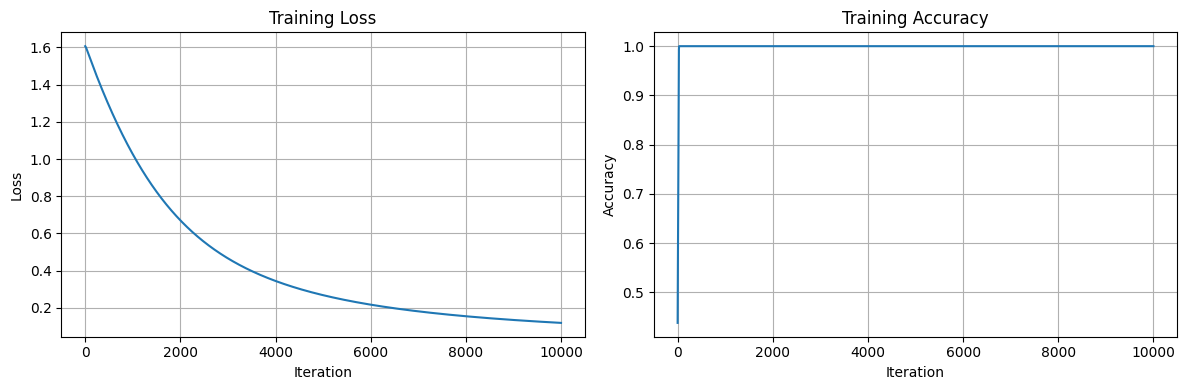

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(losses)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True)

axes[1].plot(accuracies)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].grid(True)

plt.tight_layout()
plt.show()

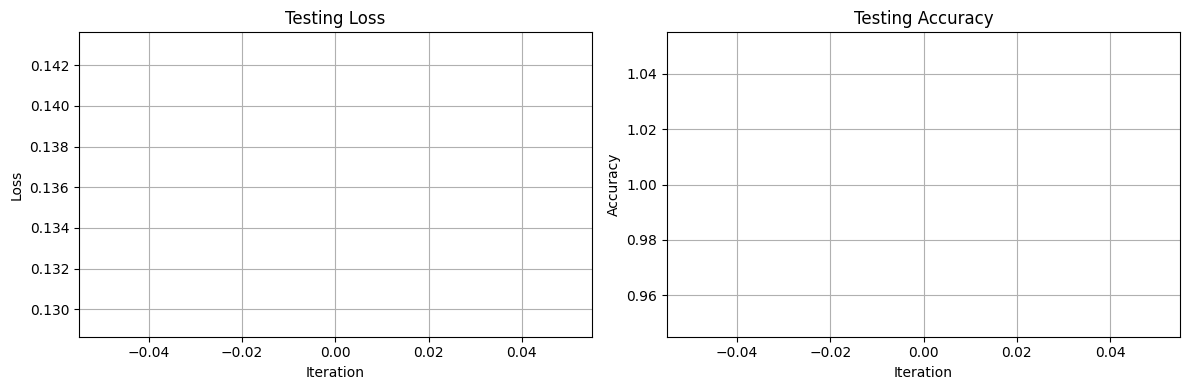

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(test_loss)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('Testing Loss')
axes[0].grid(True)

axes[1].plot(test_acc)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Testing Accuracy')
axes[1].grid(True)

plt.tight_layout()
plt.show()